Shap value for project features and content categories

guidelines:

SHAP intro: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

SHAP with Random forest: https://www.kaggle.com/code/vikumsw/explaining-random-forest-model-with-shapely-values

SHAP with XGboost: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

SHAP with catboost: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html

SHAP with LightGBM: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html



In [1]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, DMatrix
from lightgbm import LGBMClassifier, Dataset, train as lgb_train
from catboost import CatBoostClassifier, CatBoostRegressor

import json
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import classification_report

In [2]:
def select_model(model_name):
    """Selects and returns the specified model."""
    models = {
        'LinearSVC': LinearSVC(),
        'RandomForest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=2.5, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(),
        # 'CatBoost': CatBoostClassifier(verbose=0)
    }
    return models.get(model_name, RandomForestClassifier())  # Default to RandomForest if model not found

def select_explainer(model_name, model, X_train):
    """Selects the appropriate SHAP explainer based on the model."""
    if model_name in ['LinearSVC', 'RandomForest']:
        return shap.KernelExplainer(model.predict, X_train)
    elif model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
        return shap.TreeExplainer(model)
    else:
        raise ValueError(f"No SHAP explainer defined for model: {model_name}")

def target_category_filter(categories, target_category):
    """Returns 1 if the target category is in the list, else 0."""
    return 1 if isinstance(categories, list) and target_category in categories else 0


In [ ]:
def preprocess_data(data, target_column):
    """Preprocesses the data and splits it into train, test, and validation sets with stratified sampling."""
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # train and temp (70% train, 30% temp)
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_index, temp_index in stratified_split.split(X, y):
        X_train, X_temp = X.iloc[train_index], X.iloc[temp_index]
        y_train, y_temp = y.iloc[train_index], y.iloc[temp_index]

    # test and validation (30% of 20%)
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for test_index, val_index in stratified_split.split(X_temp, y_temp):
        X_test, X_val = X_temp.iloc[test_index], X_temp.iloc[val_index]
        y_test, y_val = y_temp.iloc[test_index], y_temp.iloc[val_index]

    return X_train, X_test, X_val, y_train, y_test, y_val

In [3]:
# Change your file location here na
with open('datset/AllPackages_rename_2025.json', 'r', encoding='utf-8') as file:
    raw_data = json.load(file)
    
selected_columns = ['SecurityPolicy_content_category', 'num_commits', 'num_contributors', 'num_issues', 'num_pull', 'project_age_days', 'num_stargazers']
data = []
for item in raw_data:
    filtered_item = {key: item[key] for key in selected_columns if key in item}
    data.append(filtered_item)

data = pd.DataFrame(data)
data.head()

,SecurityPolicy_content_category,num_commits,num_contributors,num_issues,num_pull,project_age_days,num_stargazers
0,[Generic policy],33019,395,18679,18679,4568,79844
1,[Reporting mechanism],1115,110,1167,504,4843,7669
2,[Reporting mechanism],13442,37,589,380,1912,16
3,"[Generic policy, Reporting mechanism]",7171,327,9479,4551,2141,33529
4,"[Reporting mechanism, User guideline, Projects...",6317,401,6522,2550,5007,52136


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       132
           1       0.24      0.60      0.34        10

    accuracy                           0.84       142
   macro avg       0.60      0.73      0.63       142
weighted avg       0.91      0.84      0.87       142



/Users/beenayaknon/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:54:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


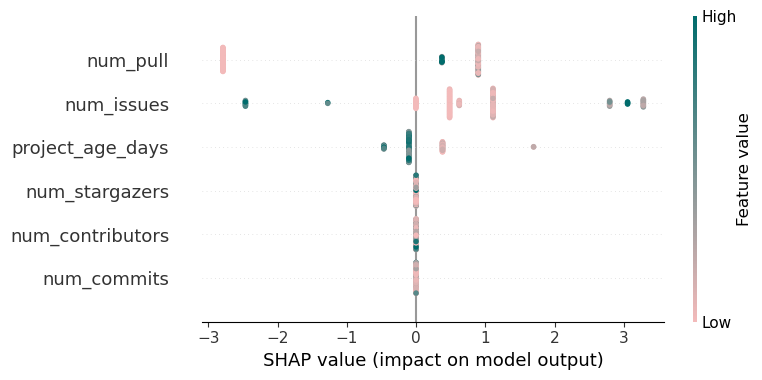

In [4]:
# Select target category and model
target_category = 'User guideline'  # Choose from: 'Generic policy', 'Reporting mechanism', 'Scope of practice', 'User guideline'
model_name = 'XGBoost'  # Choose from: 'LinearSVC', 'RandomForest', 'XGBoost', 'LightGBM', 'CatBoost'

data['SecurityPolicy_content_category'] = data['SecurityPolicy_content_category'].apply(lambda x: target_category_filter(x, target_category))

# Preprocess data
target_column = 'SecurityPolicy_content_category'
X_train, X_test, X_val, y_train, y_test, y_val = preprocess_data(data, target_column)

# Select model
model = select_model(model_name)

# Train the model
model.fit(X_train, y_train)

# Select the appropriate SHAP explainer
explainer = select_explainer(model_name, model, X_train)
shap_values = explainer.shap_values(X_test) if model_name in ['XGBoost', 'LightGBM', 'CatBoost'] else explainer(X_test)

# print report
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize feature importance
cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap)